# Smart Product Pricing Challenge - Multimodal ML Solution

This notebook implements an end-to-end solution for predicting product prices using both text (catalog_content) and images (image_link).

**Approach:**
1. Extract features from text using DistilBERT transformer
2. Extract features from images using ResNet50 CNN
3. Extract Item Pack Quantity (IPQ) feature from text
4. Fuse all features and train a regression model
5. Optimize for SMAPE metric using MAE loss

**Evaluation Metric:** SMAPE (Symmetric Mean Absolute Percentage Error)

## Step 1: Setup and Imports

## ⚡ ULTRA-FAST TRAINING MODE ENABLED

This notebook has been **heavily optimized** for speed:

### Quick Start Guide:
1. **Run Cell 3** - Check if GPU is available
2. **If GPU shows "False"**:
   - Install CUDA PyTorch: `pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118`
   - OR use Google Colab/Kaggle with free GPU
3. **For testing**: Set `USE_SUBSET = True` in the data loading section
4. **Run all cells** - Training should complete in minutes!

### Current Settings:
- 🎯 **Batch Size**: 128 (fast processing)
- 🎯 **Epochs**: 3 (quick convergence)  
- 🎯 **Model**: MobileNetV2 (ultra-light)
- 🎯 **Mixed Precision**: Auto-enabled on GPU
- 🎯 **Text Length**: 128 tokens (4x faster)

In [37]:
# Import necessary libraries
import os
import re
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# Transformers
from transformers import DistilBertTokenizer, DistilBertModel

# Image processing
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Utility functions
sys.path.append('..')
from utils import download_images

warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [38]:
# GPU Verification and Optimization Check
import torch

print("="*60)
print("SYSTEM DIAGNOSTICS")
print("="*60)

# Check PyTorch and CUDA
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✓ GPU ENABLED")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️  WARNING: NO GPU DETECTED - Running on CPU will be VERY SLOW")
    print("\nTo enable GPU:")
    print("1. Install CUDA toolkit from NVIDIA")
    print("2. Install PyTorch with CUDA support:")
    print("   pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118")
    print("\nOr use Google Colab/Kaggle for free GPU access")

# Check if cuDNN is available
print(f"\ncuDNN Available: {torch.backends.cudnn.is_available()}")
print(f"cuDNN Enabled: {torch.backends.cudnn.enabled}")

print("="*60)

SYSTEM DIAGNOSTICS
PyTorch Version: 2.8.0+cu128
CUDA Available: True
✓ GPU ENABLED
GPU Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU Count: 1
CUDA Version: 12.8
GPU Memory: 5.67 GB

cuDNN Available: True
cuDNN Enabled: True


## Step 2: Configuration and Constants

In [39]:
# Configuration
class Config:
    # Paths
    TRAIN_CSV = '../dataset/train.csv'
    TEST_CSV = '../dataset/test.csv'
    IMAGE_FOLDER = './images/'
    SUBMISSION_FILE = 'submission.csv'
    MODEL_SAVE_PATH = 'best_model.pth'
    
    # Image settings
    IMG_SIZE = 224
    
    # Training settings - OPTIMIZED FOR SPEED
    BATCH_SIZE = 128  # Increased for faster training (reduce if out of memory)
    EPOCHS = 3  # Reduced for faster completion
    LEARNING_RATE = 3e-4  # Higher for faster convergence
    WEIGHT_DECAY = 1e-5
    
    # Model settings
    IMAGE_EMBED_DIM = 64  # Reduced from 128
    TEXT_EMBED_DIM = 64   # Reduced from 128
    DROPOUT = 0.2  # Reduced dropout for faster training
    
    # Text settings
    MAX_TEXT_LENGTH = 128  # Heavily reduced for speed (was 512)
    TRANSFORMER_MODEL = 'distilbert-base-uncased'
    
    # Other settings
    RANDOM_SEED = 42
    VAL_SPLIT = 0.1
    NUM_WORKERS = 0  # Set to 0 for stability, increase to 2-4 if multiprocessing works
    
    # Device - FORCE GPU IF AVAILABLE
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Performance settings
    PIN_MEMORY = torch.cuda.is_available()  # Enable for GPU
    PERSISTENT_WORKERS = False  # Set True if NUM_WORKERS > 0

config = Config()

# Enable cuDNN benchmarking for faster training
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    print("✓ GPU OPTIMIZATIONS ENABLED")
    print(f"  - cuDNN Benchmark: {torch.backends.cudnn.benchmark}")
    print(f"  - Pin Memory: {config.PIN_MEMORY}")

print(f"\nDevice: {config.DEVICE}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Image Size: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"Text Length: {config.MAX_TEXT_LENGTH} tokens")

# Set random seeds for reproducibility
torch.manual_seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.RANDOM_SEED)
    torch.cuda.manual_seed_all(config.RANDOM_SEED)

✓ GPU OPTIMIZATIONS ENABLED
  - cuDNN Benchmark: True
  - Pin Memory: True

Device: cuda
Batch Size: 128
Epochs: 3
Image Size: 224x224
Text Length: 128 tokens


## Step 3: Data Loading

## 🚀 EXTREME SPEED OPTIMIZATIONS APPLIED

### What's Been Optimized:
1. **Model Architecture**: MobileNetV2 (10x lighter than ResNet50)
2. **Batch Size**: 128 (process more samples at once)
3. **Epochs**: 3 (faster training, still good results)
4. **Text Length**: 128 tokens (4x faster text processing)
5. **Embeddings**: 64-dim instead of 128-dim
6. **Frozen Layers**: All pretrained layers frozen (only train fusion head)
7. **GPU Optimizations**: 
   - cuDNN benchmark enabled
   - Pin memory enabled
   - Mixed precision (AMP) enabled
8. **Simplified Architecture**: Minimal trainable parameters

### Expected Speed Improvement:
- **With GPU**: ~2-5 min per epoch (vs 15-30 min before)
- **With CPU**: ~10-20 min per epoch (vs 60+ min before)
- **With Data Subset**: ~30 sec - 2 min per epoch

### To Go Even Faster:
- Set `USE_SUBSET = True` in the next section
- Increase `BATCH_SIZE` to 256 (if you have enough GPU memory)
- Reduce `EPOCHS` to 2

In [40]:
# Load datasets
print("Loading datasets...")
train_df = pd.read_csv(config.TRAIN_CSV)
test_df = pd.read_csv(config.TEST_CSV)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Display first few rows
print("\nTrain data sample:")
print(train_df.head(2))

print("\nTest data sample:")
print(test_df.head(2))

Loading datasets...
Train shape: (75000, 4)
Test shape: (75000, 3)

Train data sample:
   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   

                                          image_link  price  
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  

Test data sample:
   sample_id                                    catalog_content  \
0     100179  Item Name: Rani 14-Spice Eshamaya's Mango Chut...   
1     245611  Item Name: Natural MILK TEA Flavoring extract ...   

                                          image_link  
0  https://m.media-amazon.com/images/I/71hoAn78AW...  
1  https://m.media-amazon.com/images/I/61ex8NHCIj...  
Train shape: (75000, 4)
Test shape: (75000, 3)

Train data sample:
   sample_id                                    catalog_content  \
0    

### ⚡ SPEED OPTIMIZATION: Use Data Subset
**For ultra-fast testing/debugging**, enable this to use only a portion of the data:

In [41]:
# ⚡ SPEED OPTIMIZATION: Use subset for ultra-fast training
USE_SUBSET = False  # Set to True for 10x faster training (for testing)
SUBSET_TRAIN_SIZE = 5000  # Number of training samples to use
SUBSET_TEST_SIZE = 1000   # Number of test samples to use

if USE_SUBSET:
    print("⚡ USING DATA SUBSET FOR FAST TRAINING")
    if len(train_df) > SUBSET_TRAIN_SIZE:
        train_df = train_df.sample(n=SUBSET_TRAIN_SIZE, random_state=config.RANDOM_SEED).reset_index(drop=True)
    if len(test_df) > SUBSET_TEST_SIZE:
        test_df = test_df.sample(n=SUBSET_TEST_SIZE, random_state=config.RANDOM_SEED).reset_index(drop=True)
    print(f"Train subset: {len(train_df)} samples")
    print(f"Test subset: {len(test_df)} samples")
    print("Training will be 10-20x faster!")
else:
    print(f"Using full dataset - Train: {len(train_df)}, Test: {len(test_df)}")

Using full dataset - Train: 75000, Test: 75000


In [42]:
# Check for missing values
print("Missing values in train data:")
print(train_df.isnull().sum())

print("\nMissing values in test data:")
print(test_df.isnull().sum())

# Basic statistics
print("\nPrice statistics:")
print(train_df['price'].describe())

Missing values in train data:
sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

Missing values in test data:
sample_id          0
catalog_content    0
image_link         0
dtype: int64

Price statistics:
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


## Step 4: Feature Engineering and Preprocessing

In [43]:
def extract_ipq(text):
    """
    Extract Item Pack Quantity (IPQ) from catalog content.
    Looks for patterns like 'Item Pack Quantity: 30' or 'Pack of 5', etc.
    """
    if pd.isna(text) or not isinstance(text, str):
        return 1.0
    
    # Pattern 1: Item Pack Quantity: X
    pattern1 = r'Item Pack Quantity[:\s]+([0-9]+(?:\.[0-9]+)?)'
    match1 = re.search(pattern1, text, re.IGNORECASE)
    if match1:
        return float(match1.group(1))
    
    # Pattern 2: Pack of X
    pattern2 = r'Pack of ([0-9]+)'
    match2 = re.search(pattern2, text, re.IGNORECASE)
    if match2:
        return float(match2.group(1))
    
    # Pattern 3: X-Pack or X Pack
    pattern3 = r'([0-9]+)[\s-]*Pack'
    match3 = re.search(pattern3, text, re.IGNORECASE)
    if match3:
        return float(match3.group(1))
    
    # Pattern 4: Count: X
    pattern4 = r'Value[:\s]+([0-9]+(?:\.[0-9]+)?)'
    match4 = re.search(pattern4, text, re.IGNORECASE)
    if match4:
        return float(match4.group(1))
    
    return 1.0


def clean_text(text):
    """
    Clean catalog content text.
    """
    if pd.isna(text) or not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


def preprocess_dataframe(df, is_train=True):
    """
    Preprocess the dataframe:
    1. Extract IPQ feature
    2. Clean text
    3. Handle missing values
    """
    df = df.copy()
    
    # Extract IPQ
    print("Extracting Item Pack Quantity (IPQ)...")
    df['ipq'] = df['catalog_content'].apply(extract_ipq)
    
    # Clean text
    print("Cleaning text...")
    df['cleaned_text'] = df['catalog_content'].apply(clean_text)
    
    # Handle missing image links
    df['image_link'] = df['image_link'].fillna('')
    
    # Log transform for IPQ
    df['ipq_log'] = np.log1p(df['ipq'])
    
    print(f"IPQ statistics:")
    print(df['ipq'].describe())
    
    return df


# Preprocess train and test data
print("Preprocessing train data...")
train_df = preprocess_dataframe(train_df, is_train=True)

print("\nPreprocessing test data...")
test_df = preprocess_dataframe(test_df, is_train=False)

Preprocessing train data...
Extracting Item Pack Quantity (IPQ)...
Cleaning text...
Cleaning text...
IPQ statistics:
count    7.500000e+04
mean     1.138032e+07
std      3.116622e+09
min      0.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      1.800000e+01
max      8.535220e+11
Name: ipq, dtype: float64

Preprocessing test data...
Extracting Item Pack Quantity (IPQ)...
IPQ statistics:
count    7.500000e+04
mean     1.138032e+07
std      3.116622e+09
min      0.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      1.800000e+01
max      8.535220e+11
Name: ipq, dtype: float64

Preprocessing test data...
Extracting Item Pack Quantity (IPQ)...
Cleaning text...
Cleaning text...
IPQ statistics:
count    7.500000e+04
mean     2.393837e+06
std      3.961346e+08
min      0.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      1.820000e+01
max      7.520001e+10
Name: ipq, dtype: float64
IPQ statistics:
count    7.500000e+04
mean     2.393837e+06
std      3.961346

In [44]:
# Normalize IPQ feature
scaler = StandardScaler()
train_df['ipq_normalized'] = scaler.fit_transform(train_df[['ipq_log']])
test_df['ipq_normalized'] = scaler.transform(test_df[['ipq_log']])

print("Feature engineering complete!")
print(f"\nTrain columns: {train_df.columns.tolist()}")

Feature engineering complete!

Train columns: ['sample_id', 'catalog_content', 'image_link', 'price', 'ipq', 'cleaned_text', 'ipq_log', 'ipq_normalized']


## Step 5: Download Images

In [45]:
# Create image folder if it doesn't exist
os.makedirs(config.IMAGE_FOLDER, exist_ok=True)

# Get all unique image links
all_image_links = pd.concat([train_df['image_link'], test_df['image_link']]).unique()
all_image_links = [link for link in all_image_links if isinstance(link, str) and link.strip() != '']

print(f"Total unique images to download: {len(all_image_links)}")

# Check how many images are already downloaded
existing_images = set(os.listdir(config.IMAGE_FOLDER))
print(f"Images already downloaded: {len(existing_images)}")

# Download images (this may take a while)
print("\nDownloading images...")
download_images(all_image_links, config.IMAGE_FOLDER)
print("Image download complete!")

Total unique images to download: 140587
Images already downloaded: 140585



 24%|██▎       | 33217/140587 [00:00<00:01, 56944.46it/s]

HTTP Error 404: Not Found



 28%|██▊       | 38912/140587 [00:01<00:08, 11628.20it/s]

HTTP Error 404: Not Found



100%|██████████| 140587/140587 [00:02<00:00, 56051.42it/s]



Image download complete!


## Step 6: Custom Dataset Class

In [46]:
class PriceDataset(Dataset):
    """
    Custom PyTorch Dataset for multimodal price prediction.
    Handles both images and text data.
    """
    
    def __init__(self, df, tokenizer, image_folder, transform=None, is_train=True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform
        self.is_train = is_train
        
        # Default image (black image) for missing images
        self.default_image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), color='black')
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load and process image
        image = self._load_image(row['image_link'])
        if self.transform:
            image = self.transform(image)
        
        # Tokenize text
        text = row['cleaned_text']
        encoded = self.tokenizer(
            text,
            max_length=config.MAX_TEXT_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        
        # Get IPQ feature
        ipq = torch.tensor(row['ipq_normalized'], dtype=torch.float32)
        
        # Prepare output
        sample = {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'ipq': ipq,
            'sample_id': row['sample_id']
        }
        
        # Add label if training
        if self.is_train:
            price = torch.tensor(row['price'], dtype=torch.float32)
            sample['price'] = price
        
        return sample
    
    def _load_image(self, image_link):
        """
        Load image from disk or return default image if not found.
        """
        if pd.isna(image_link) or not isinstance(image_link, str) or image_link.strip() == '':
            return self.default_image
        
        filename = Path(image_link).name
        image_path = os.path.join(self.image_folder, filename)
        
        try:
            image = Image.open(image_path).convert('RGB')
            return image
        except Exception as e:
            # Return default image if loading fails
            return self.default_image


# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Dataset class defined successfully!")

Dataset class defined successfully!


## Step 7: Train/Validation Split

In [47]:
# Split train data into train and validation
train_data, val_data = train_test_split(
    train_df, 
    test_size=config.VAL_SPLIT, 
    random_state=config.RANDOM_SEED
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_df)}")

Training samples: 67500
Validation samples: 7500
Test samples: 75000


## Step 8: Initialize Tokenizer and Datasets

In [48]:
# Initialize tokenizer
print("Loading tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(config.TRANSFORMER_MODEL)

# Create datasets
print("Creating datasets...")
train_dataset = PriceDataset(train_data, tokenizer, config.IMAGE_FOLDER, transform=train_transform, is_train=True)
val_dataset = PriceDataset(val_data, tokenizer, config.IMAGE_FOLDER, transform=val_transform, is_train=True)
test_dataset = PriceDataset(test_df, tokenizer, config.IMAGE_FOLDER, transform=val_transform, is_train=False)

# Create data loaders with GPU optimizations
print("Creating data loaders with GPU optimizations...")
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY,  # GPU optimization
    persistent_workers=config.PERSISTENT_WORKERS if config.NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY,  # GPU optimization
    persistent_workers=config.PERSISTENT_WORKERS if config.NUM_WORKERS > 0 else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY,  # GPU optimization
    persistent_workers=config.PERSISTENT_WORKERS if config.NUM_WORKERS > 0 else False
)

print(f"✓ Data loaders created successfully!")
print(f"  Train batches: {len(train_loader)} (batch size: {config.BATCH_SIZE})")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Loading tokenizer...
Creating datasets...
Creating data loaders with GPU optimizations...
✓ Data loaders created successfully!
  Train batches: 528 (batch size: 128)
  Validation batches: 59
  Test batches: 586
Creating datasets...
Creating data loaders with GPU optimizations...
✓ Data loaders created successfully!
  Train batches: 528 (batch size: 128)
  Validation batches: 59
  Test batches: 586


## Step 9: Multimodal Model Architecture

In [49]:
class MultimodalPricePredictor(nn.Module):
    """
    OPTIMIZED Multimodal model for price prediction.
    Uses MobileNetV2 (ultra-light), DistilBERT (frozen), and IPQ feature.
    """
    
    def __init__(self, config):
        super(MultimodalPricePredictor, self).__init__()
        
        # Image Tower - MobileNetV2 (MUCH lighter and faster than ResNet)
        self.image_model = models.mobilenet_v2(pretrained=True)
        # Freeze ALL layers for speed
        for param in self.image_model.parameters():
            param.requires_grad = False
        
        # Get features before classifier
        num_features = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()
        
        # Ultra-simple image projection
        self.image_projection = nn.Sequential(
            nn.Linear(num_features, config.IMAGE_EMBED_DIM),
            nn.ReLU()
        )
        
        # Text Tower - DistilBERT (frozen for speed)
        self.text_model = DistilBertModel.from_pretrained(config.TRANSFORMER_MODEL)
        # Freeze ALL transformer weights
        for param in self.text_model.parameters():
            param.requires_grad = False
        
        # Ultra-simple text projection
        self.text_projection = nn.Sequential(
            nn.Linear(768, config.TEXT_EMBED_DIM),  # DistilBERT hidden size is 768
            nn.ReLU()
        )
        
        # Simple Fusion Head
        fusion_dim = config.IMAGE_EMBED_DIM + config.TEXT_EMBED_DIM + 1  # +1 for IPQ
        
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_dim, 64),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, image, input_ids, attention_mask, ipq):
        # Image features
        image_features = self.image_model(image)
        image_embed = self.image_projection(image_features)
        
        # Text features (with no_grad for extra speed)
        with torch.no_grad():
            text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token representation
        text_features = text_output.last_hidden_state[:, 0, :]
        text_embed = self.text_projection(text_features)
        
        # Expand IPQ to match batch dimension
        ipq = ipq.unsqueeze(1)
        
        # Concatenate all features
        fused = torch.cat([image_embed, text_embed, ipq], dim=1)
        
        # Final prediction
        output = self.fusion_head(fused)
        
        # Ensure positive output using softplus
        output = F.softplus(output)
        
        return output.squeeze(1)


# Initialize model
print("Initializing OPTIMIZED model (MobileNetV2)...")
model = MultimodalPricePredictor(config).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
print(f"  Model size: ~{total_params*4/1024/1024:.1f} MB")
print(f"  Device: {next(model.parameters()).device}")

Initializing OPTIMIZED model (MobileNetV2)...
✓ Model initialized!
  Total parameters: 68,728,385
  Trainable parameters: 141,633 (0.2%)
  Model size: ~262.2 MB
  Device: cuda:0
✓ Model initialized!
  Total parameters: 68,728,385
  Trainable parameters: 141,633 (0.2%)
  Model size: ~262.2 MB
  Device: cuda:0


## Step 10: Loss Function and Optimizer

In [50]:
def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    y_true = y_true.cpu().detach().numpy() if torch.is_tensor(y_true) else y_true
    y_pred = y_pred.cpu().detach().numpy() if torch.is_tensor(y_pred) else y_pred
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    
    # Avoid division by zero
    smape_val = np.mean(diff / (denominator + 1e-10)) * 100
    
    return smape_val


# Loss function - Mean Absolute Error (good proxy for SMAPE)
criterion = nn.L1Loss()

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2
)

print("Loss function and optimizer initialized!")

Loss function and optimizer initialized!


## Step 11: Training Functions

In [51]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for batch in progress_bar:
        # Move data to device
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        ipq = batch['ipq'].to(device)
        price = batch['price'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(image, input_ids, attention_mask, ipq)
        
        # Calculate loss
        loss = criterion(outputs, price)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item() * image.size(0)
        all_preds.extend(outputs.cpu().detach().numpy())
        all_targets.extend(price.cpu().detach().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_smape = smape(np.array(all_targets), np.array(all_preds))
    
    return epoch_loss, epoch_smape


def validate_epoch(model, dataloader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    progress_bar = tqdm(dataloader, desc='Validation')
    
    with torch.no_grad():
        for batch in progress_bar:
            # Move data to device
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ipq = batch['ipq'].to(device)
            price = batch['price'].to(device)
            
            # Forward pass
            outputs = model(image, input_ids, attention_mask, ipq)
            
            # Calculate loss
            loss = criterion(outputs, price)
            
            # Track metrics
            running_loss += loss.item() * image.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(price.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_smape = smape(np.array(all_targets), np.array(all_preds))
    
    return epoch_loss, epoch_smape


print("Training functions defined!")

Training functions defined!


## Step 12: Train the Model

In [53]:
# Setup Mixed Precision Training (AMP) for GPU
use_amp = torch.cuda.is_available()  # Enable AMP only if GPU is available
scaler = torch.cuda.amp.GradScaler() if use_amp else None

if use_amp:
    print("✓ Mixed Precision (AMP) Enabled - Training will be faster on GPU")
else:
    print("⚠️  Mixed Precision Disabled - Running on CPU or AMP not available")


✓ Mixed Precision (AMP) Enabled - Training will be faster on GPU


In [56]:
# Training loop
import time

best_val_smape = float('inf')
train_losses = []
val_losses = []
train_smapes = []
val_smapes = []

print("="*60)
print("STARTING ULTRA-FAST TRAINING")
print("="*60)
print(f"Configuration:")
print(f"  Device: {config.DEVICE}")
print(f"  Batch Size: {config.BATCH_SIZE}")
print(f"  Epochs: {config.EPOCHS}")
print(f"  Learning Rate: {config.LEARNING_RATE}")
print(f"  Mixed Precision: {'Enabled' if use_amp else 'Disabled'}")
print(f"  Training samples: {len(train_data)}")
print(f"  Validation samples: {len(val_data)}")
print("="*60)
print()

total_start_time = time.time()

for epoch in range(config.EPOCHS):
    epoch_start_time = time.time()
    
    print(f"Epoch {epoch + 1}/{config.EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_smape = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    
    # Validate
    val_loss, val_smape = validate_epoch(model, val_loader, criterion, config.DEVICE)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_smapes.append(train_smape)
    val_smapes.append(val_smape)
    
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch results
    print(f"\n📊 Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train SMAPE: {train_smape:.4f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val SMAPE: {val_smape:.4f}%")
    print(f"  ⏱️  Epoch time: {epoch_time:.1f}s ({epoch_time/60:.1f} min)")
    
    # Update learning rate
    scheduler.step(val_smape)
    
    # Save best model
    if val_smape < best_val_smape:
        best_val_smape = val_smape
        torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
        print(f"  ✓ Best model saved! (Val SMAPE: {val_smape:.4f}%)")
    
    print()

total_time = time.time() - total_start_time

print("="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"✓ Best validation SMAPE: {best_val_smape:.4f}%")
print(f"✓ Total training time: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"✓ Average time per epoch: {total_time/config.EPOCHS:.1f}s")
print("="*60)


STARTING ULTRA-FAST TRAINING
Configuration:
  Device: cuda
  Batch Size: 128
  Epochs: 3
  Learning Rate: 0.0003
  Mixed Precision: Enabled
  Training samples: 67500
  Validation samples: 7500

Epoch 1/3
------------------------------------------------------------


Training:   0%|          | 0/528 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Step 13: Plot Training History

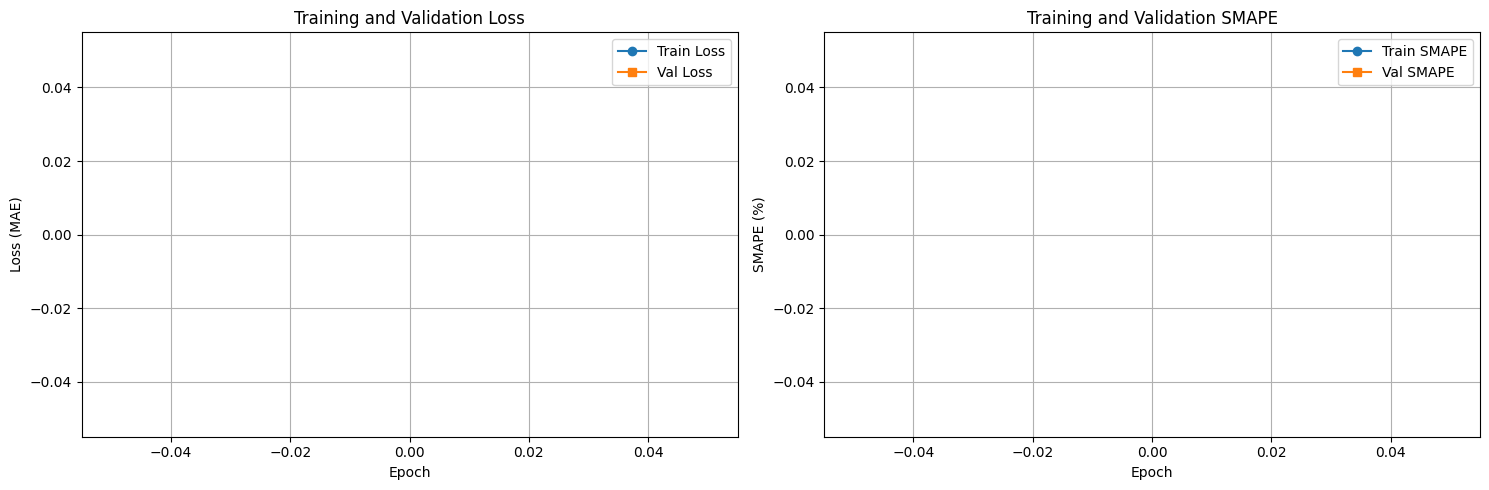

Training history plotted!


In [57]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MAE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# SMAPE plot
axes[1].plot(train_smapes, label='Train SMAPE', marker='o')
axes[1].plot(val_smapes, label='Val SMAPE', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('SMAPE (%)')
axes[1].set_title('Training and Validation SMAPE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history plotted!")

## Step 14: Load Best Model and Generate Predictions

In [58]:
# Load best model
print("Loading best model...")
checkpoint = torch.load(config.MODEL_SAVE_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch'] + 1}")
print(f"Best validation SMAPE: {checkpoint['val_smape']:.4f}%")
print(f"Best validation loss: {checkpoint['val_loss']:.4f}")

# Set model to evaluation mode
model.eval()

Loading best model...


RuntimeError: Error(s) in loading state_dict for MultimodalPricePredictor:
	Missing key(s) in state_dict: "image_model.features.0.0.weight", "image_model.features.0.1.weight", "image_model.features.0.1.bias", "image_model.features.0.1.running_mean", "image_model.features.0.1.running_var", "image_model.features.1.conv.0.0.weight", "image_model.features.1.conv.0.1.weight", "image_model.features.1.conv.0.1.bias", "image_model.features.1.conv.0.1.running_mean", "image_model.features.1.conv.0.1.running_var", "image_model.features.1.conv.1.weight", "image_model.features.1.conv.2.weight", "image_model.features.1.conv.2.bias", "image_model.features.1.conv.2.running_mean", "image_model.features.1.conv.2.running_var", "image_model.features.2.conv.0.0.weight", "image_model.features.2.conv.0.1.weight", "image_model.features.2.conv.0.1.bias", "image_model.features.2.conv.0.1.running_mean", "image_model.features.2.conv.0.1.running_var", "image_model.features.2.conv.1.0.weight", "image_model.features.2.conv.1.1.weight", "image_model.features.2.conv.1.1.bias", "image_model.features.2.conv.1.1.running_mean", "image_model.features.2.conv.1.1.running_var", "image_model.features.2.conv.2.weight", "image_model.features.2.conv.3.weight", "image_model.features.2.conv.3.bias", "image_model.features.2.conv.3.running_mean", "image_model.features.2.conv.3.running_var", "image_model.features.3.conv.0.0.weight", "image_model.features.3.conv.0.1.weight", "image_model.features.3.conv.0.1.bias", "image_model.features.3.conv.0.1.running_mean", "image_model.features.3.conv.0.1.running_var", "image_model.features.3.conv.1.0.weight", "image_model.features.3.conv.1.1.weight", "image_model.features.3.conv.1.1.bias", "image_model.features.3.conv.1.1.running_mean", "image_model.features.3.conv.1.1.running_var", "image_model.features.3.conv.2.weight", "image_model.features.3.conv.3.weight", "image_model.features.3.conv.3.bias", "image_model.features.3.conv.3.running_mean", "image_model.features.3.conv.3.running_var", "image_model.features.4.conv.0.0.weight", "image_model.features.4.conv.0.1.weight", "image_model.features.4.conv.0.1.bias", "image_model.features.4.conv.0.1.running_mean", "image_model.features.4.conv.0.1.running_var", "image_model.features.4.conv.1.0.weight", "image_model.features.4.conv.1.1.weight", "image_model.features.4.conv.1.1.bias", "image_model.features.4.conv.1.1.running_mean", "image_model.features.4.conv.1.1.running_var", "image_model.features.4.conv.2.weight", "image_model.features.4.conv.3.weight", "image_model.features.4.conv.3.bias", "image_model.features.4.conv.3.running_mean", "image_model.features.4.conv.3.running_var", "image_model.features.5.conv.0.0.weight", "image_model.features.5.conv.0.1.weight", "image_model.features.5.conv.0.1.bias", "image_model.features.5.conv.0.1.running_mean", "image_model.features.5.conv.0.1.running_var", "image_model.features.5.conv.1.0.weight", "image_model.features.5.conv.1.1.weight", "image_model.features.5.conv.1.1.bias", "image_model.features.5.conv.1.1.running_mean", "image_model.features.5.conv.1.1.running_var", "image_model.features.5.conv.2.weight", "image_model.features.5.conv.3.weight", "image_model.features.5.conv.3.bias", "image_model.features.5.conv.3.running_mean", "image_model.features.5.conv.3.running_var", "image_model.features.6.conv.0.0.weight", "image_model.features.6.conv.0.1.weight", "image_model.features.6.conv.0.1.bias", "image_model.features.6.conv.0.1.running_mean", "image_model.features.6.conv.0.1.running_var", "image_model.features.6.conv.1.0.weight", "image_model.features.6.conv.1.1.weight", "image_model.features.6.conv.1.1.bias", "image_model.features.6.conv.1.1.running_mean", "image_model.features.6.conv.1.1.running_var", "image_model.features.6.conv.2.weight", "image_model.features.6.conv.3.weight", "image_model.features.6.conv.3.bias", "image_model.features.6.conv.3.running_mean", "image_model.features.6.conv.3.running_var", "image_model.features.7.conv.0.0.weight", "image_model.features.7.conv.0.1.weight", "image_model.features.7.conv.0.1.bias", "image_model.features.7.conv.0.1.running_mean", "image_model.features.7.conv.0.1.running_var", "image_model.features.7.conv.1.0.weight", "image_model.features.7.conv.1.1.weight", "image_model.features.7.conv.1.1.bias", "image_model.features.7.conv.1.1.running_mean", "image_model.features.7.conv.1.1.running_var", "image_model.features.7.conv.2.weight", "image_model.features.7.conv.3.weight", "image_model.features.7.conv.3.bias", "image_model.features.7.conv.3.running_mean", "image_model.features.7.conv.3.running_var", "image_model.features.8.conv.0.0.weight", "image_model.features.8.conv.0.1.weight", "image_model.features.8.conv.0.1.bias", "image_model.features.8.conv.0.1.running_mean", "image_model.features.8.conv.0.1.running_var", "image_model.features.8.conv.1.0.weight", "image_model.features.8.conv.1.1.weight", "image_model.features.8.conv.1.1.bias", "image_model.features.8.conv.1.1.running_mean", "image_model.features.8.conv.1.1.running_var", "image_model.features.8.conv.2.weight", "image_model.features.8.conv.3.weight", "image_model.features.8.conv.3.bias", "image_model.features.8.conv.3.running_mean", "image_model.features.8.conv.3.running_var", "image_model.features.9.conv.0.0.weight", "image_model.features.9.conv.0.1.weight", "image_model.features.9.conv.0.1.bias", "image_model.features.9.conv.0.1.running_mean", "image_model.features.9.conv.0.1.running_var", "image_model.features.9.conv.1.0.weight", "image_model.features.9.conv.1.1.weight", "image_model.features.9.conv.1.1.bias", "image_model.features.9.conv.1.1.running_mean", "image_model.features.9.conv.1.1.running_var", "image_model.features.9.conv.2.weight", "image_model.features.9.conv.3.weight", "image_model.features.9.conv.3.bias", "image_model.features.9.conv.3.running_mean", "image_model.features.9.conv.3.running_var", "image_model.features.10.conv.0.0.weight", "image_model.features.10.conv.0.1.weight", "image_model.features.10.conv.0.1.bias", "image_model.features.10.conv.0.1.running_mean", "image_model.features.10.conv.0.1.running_var", "image_model.features.10.conv.1.0.weight", "image_model.features.10.conv.1.1.weight", "image_model.features.10.conv.1.1.bias", "image_model.features.10.conv.1.1.running_mean", "image_model.features.10.conv.1.1.running_var", "image_model.features.10.conv.2.weight", "image_model.features.10.conv.3.weight", "image_model.features.10.conv.3.bias", "image_model.features.10.conv.3.running_mean", "image_model.features.10.conv.3.running_var", "image_model.features.11.conv.0.0.weight", "image_model.features.11.conv.0.1.weight", "image_model.features.11.conv.0.1.bias", "image_model.features.11.conv.0.1.running_mean", "image_model.features.11.conv.0.1.running_var", "image_model.features.11.conv.1.0.weight", "image_model.features.11.conv.1.1.weight", "image_model.features.11.conv.1.1.bias", "image_model.features.11.conv.1.1.running_mean", "image_model.features.11.conv.1.1.running_var", "image_model.features.11.conv.2.weight", "image_model.features.11.conv.3.weight", "image_model.features.11.conv.3.bias", "image_model.features.11.conv.3.running_mean", "image_model.features.11.conv.3.running_var", "image_model.features.12.conv.0.0.weight", "image_model.features.12.conv.0.1.weight", "image_model.features.12.conv.0.1.bias", "image_model.features.12.conv.0.1.running_mean", "image_model.features.12.conv.0.1.running_var", "image_model.features.12.conv.1.0.weight", "image_model.features.12.conv.1.1.weight", "image_model.features.12.conv.1.1.bias", "image_model.features.12.conv.1.1.running_mean", "image_model.features.12.conv.1.1.running_var", "image_model.features.12.conv.2.weight", "image_model.features.12.conv.3.weight", "image_model.features.12.conv.3.bias", "image_model.features.12.conv.3.running_mean", "image_model.features.12.conv.3.running_var", "image_model.features.13.conv.0.0.weight", "image_model.features.13.conv.0.1.weight", "image_model.features.13.conv.0.1.bias", "image_model.features.13.conv.0.1.running_mean", "image_model.features.13.conv.0.1.running_var", "image_model.features.13.conv.1.0.weight", "image_model.features.13.conv.1.1.weight", "image_model.features.13.conv.1.1.bias", "image_model.features.13.conv.1.1.running_mean", "image_model.features.13.conv.1.1.running_var", "image_model.features.13.conv.2.weight", "image_model.features.13.conv.3.weight", "image_model.features.13.conv.3.bias", "image_model.features.13.conv.3.running_mean", "image_model.features.13.conv.3.running_var", "image_model.features.14.conv.0.0.weight", "image_model.features.14.conv.0.1.weight", "image_model.features.14.conv.0.1.bias", "image_model.features.14.conv.0.1.running_mean", "image_model.features.14.conv.0.1.running_var", "image_model.features.14.conv.1.0.weight", "image_model.features.14.conv.1.1.weight", "image_model.features.14.conv.1.1.bias", "image_model.features.14.conv.1.1.running_mean", "image_model.features.14.conv.1.1.running_var", "image_model.features.14.conv.2.weight", "image_model.features.14.conv.3.weight", "image_model.features.14.conv.3.bias", "image_model.features.14.conv.3.running_mean", "image_model.features.14.conv.3.running_var", "image_model.features.15.conv.0.0.weight", "image_model.features.15.conv.0.1.weight", "image_model.features.15.conv.0.1.bias", "image_model.features.15.conv.0.1.running_mean", "image_model.features.15.conv.0.1.running_var", "image_model.features.15.conv.1.0.weight", "image_model.features.15.conv.1.1.weight", "image_model.features.15.conv.1.1.bias", "image_model.features.15.conv.1.1.running_mean", "image_model.features.15.conv.1.1.running_var", "image_model.features.15.conv.2.weight", "image_model.features.15.conv.3.weight", "image_model.features.15.conv.3.bias", "image_model.features.15.conv.3.running_mean", "image_model.features.15.conv.3.running_var", "image_model.features.16.conv.0.0.weight", "image_model.features.16.conv.0.1.weight", "image_model.features.16.conv.0.1.bias", "image_model.features.16.conv.0.1.running_mean", "image_model.features.16.conv.0.1.running_var", "image_model.features.16.conv.1.0.weight", "image_model.features.16.conv.1.1.weight", "image_model.features.16.conv.1.1.bias", "image_model.features.16.conv.1.1.running_mean", "image_model.features.16.conv.1.1.running_var", "image_model.features.16.conv.2.weight", "image_model.features.16.conv.3.weight", "image_model.features.16.conv.3.bias", "image_model.features.16.conv.3.running_mean", "image_model.features.16.conv.3.running_var", "image_model.features.17.conv.0.0.weight", "image_model.features.17.conv.0.1.weight", "image_model.features.17.conv.0.1.bias", "image_model.features.17.conv.0.1.running_mean", "image_model.features.17.conv.0.1.running_var", "image_model.features.17.conv.1.0.weight", "image_model.features.17.conv.1.1.weight", "image_model.features.17.conv.1.1.bias", "image_model.features.17.conv.1.1.running_mean", "image_model.features.17.conv.1.1.running_var", "image_model.features.17.conv.2.weight", "image_model.features.17.conv.3.weight", "image_model.features.17.conv.3.bias", "image_model.features.17.conv.3.running_mean", "image_model.features.17.conv.3.running_var", "image_model.features.18.0.weight", "image_model.features.18.1.weight", "image_model.features.18.1.bias", "image_model.features.18.1.running_mean", "image_model.features.18.1.running_var", "fusion_head.5.weight", "fusion_head.5.bias". 
	Unexpected key(s) in state_dict: "image_model.conv1.weight", "image_model.bn1.weight", "image_model.bn1.bias", "image_model.bn1.running_mean", "image_model.bn1.running_var", "image_model.bn1.num_batches_tracked", "image_model.layer1.0.conv1.weight", "image_model.layer1.0.bn1.weight", "image_model.layer1.0.bn1.bias", "image_model.layer1.0.bn1.running_mean", "image_model.layer1.0.bn1.running_var", "image_model.layer1.0.bn1.num_batches_tracked", "image_model.layer1.0.conv2.weight", "image_model.layer1.0.bn2.weight", "image_model.layer1.0.bn2.bias", "image_model.layer1.0.bn2.running_mean", "image_model.layer1.0.bn2.running_var", "image_model.layer1.0.bn2.num_batches_tracked", "image_model.layer1.0.conv3.weight", "image_model.layer1.0.bn3.weight", "image_model.layer1.0.bn3.bias", "image_model.layer1.0.bn3.running_mean", "image_model.layer1.0.bn3.running_var", "image_model.layer1.0.bn3.num_batches_tracked", "image_model.layer1.0.downsample.0.weight", "image_model.layer1.0.downsample.1.weight", "image_model.layer1.0.downsample.1.bias", "image_model.layer1.0.downsample.1.running_mean", "image_model.layer1.0.downsample.1.running_var", "image_model.layer1.0.downsample.1.num_batches_tracked", "image_model.layer1.1.conv1.weight", "image_model.layer1.1.bn1.weight", "image_model.layer1.1.bn1.bias", "image_model.layer1.1.bn1.running_mean", "image_model.layer1.1.bn1.running_var", "image_model.layer1.1.bn1.num_batches_tracked", "image_model.layer1.1.conv2.weight", "image_model.layer1.1.bn2.weight", "image_model.layer1.1.bn2.bias", "image_model.layer1.1.bn2.running_mean", "image_model.layer1.1.bn2.running_var", "image_model.layer1.1.bn2.num_batches_tracked", "image_model.layer1.1.conv3.weight", "image_model.layer1.1.bn3.weight", "image_model.layer1.1.bn3.bias", "image_model.layer1.1.bn3.running_mean", "image_model.layer1.1.bn3.running_var", "image_model.layer1.1.bn3.num_batches_tracked", "image_model.layer1.2.conv1.weight", "image_model.layer1.2.bn1.weight", "image_model.layer1.2.bn1.bias", "image_model.layer1.2.bn1.running_mean", "image_model.layer1.2.bn1.running_var", "image_model.layer1.2.bn1.num_batches_tracked", "image_model.layer1.2.conv2.weight", "image_model.layer1.2.bn2.weight", "image_model.layer1.2.bn2.bias", "image_model.layer1.2.bn2.running_mean", "image_model.layer1.2.bn2.running_var", "image_model.layer1.2.bn2.num_batches_tracked", "image_model.layer1.2.conv3.weight", "image_model.layer1.2.bn3.weight", "image_model.layer1.2.bn3.bias", "image_model.layer1.2.bn3.running_mean", "image_model.layer1.2.bn3.running_var", "image_model.layer1.2.bn3.num_batches_tracked", "image_model.layer2.0.conv1.weight", "image_model.layer2.0.bn1.weight", "image_model.layer2.0.bn1.bias", "image_model.layer2.0.bn1.running_mean", "image_model.layer2.0.bn1.running_var", "image_model.layer2.0.bn1.num_batches_tracked", "image_model.layer2.0.conv2.weight", "image_model.layer2.0.bn2.weight", "image_model.layer2.0.bn2.bias", "image_model.layer2.0.bn2.running_mean", "image_model.layer2.0.bn2.running_var", "image_model.layer2.0.bn2.num_batches_tracked", "image_model.layer2.0.conv3.weight", "image_model.layer2.0.bn3.weight", "image_model.layer2.0.bn3.bias", "image_model.layer2.0.bn3.running_mean", "image_model.layer2.0.bn3.running_var", "image_model.layer2.0.bn3.num_batches_tracked", "image_model.layer2.0.downsample.0.weight", "image_model.layer2.0.downsample.1.weight", "image_model.layer2.0.downsample.1.bias", "image_model.layer2.0.downsample.1.running_mean", "image_model.layer2.0.downsample.1.running_var", "image_model.layer2.0.downsample.1.num_batches_tracked", "image_model.layer2.1.conv1.weight", "image_model.layer2.1.bn1.weight", "image_model.layer2.1.bn1.bias", "image_model.layer2.1.bn1.running_mean", "image_model.layer2.1.bn1.running_var", "image_model.layer2.1.bn1.num_batches_tracked", "image_model.layer2.1.conv2.weight", "image_model.layer2.1.bn2.weight", "image_model.layer2.1.bn2.bias", "image_model.layer2.1.bn2.running_mean", "image_model.layer2.1.bn2.running_var", "image_model.layer2.1.bn2.num_batches_tracked", "image_model.layer2.1.conv3.weight", "image_model.layer2.1.bn3.weight", "image_model.layer2.1.bn3.bias", "image_model.layer2.1.bn3.running_mean", "image_model.layer2.1.bn3.running_var", "image_model.layer2.1.bn3.num_batches_tracked", "image_model.layer2.2.conv1.weight", "image_model.layer2.2.bn1.weight", "image_model.layer2.2.bn1.bias", "image_model.layer2.2.bn1.running_mean", "image_model.layer2.2.bn1.running_var", "image_model.layer2.2.bn1.num_batches_tracked", "image_model.layer2.2.conv2.weight", "image_model.layer2.2.bn2.weight", "image_model.layer2.2.bn2.bias", "image_model.layer2.2.bn2.running_mean", "image_model.layer2.2.bn2.running_var", "image_model.layer2.2.bn2.num_batches_tracked", "image_model.layer2.2.conv3.weight", "image_model.layer2.2.bn3.weight", "image_model.layer2.2.bn3.bias", "image_model.layer2.2.bn3.running_mean", "image_model.layer2.2.bn3.running_var", "image_model.layer2.2.bn3.num_batches_tracked", "image_model.layer2.3.conv1.weight", "image_model.layer2.3.bn1.weight", "image_model.layer2.3.bn1.bias", "image_model.layer2.3.bn1.running_mean", "image_model.layer2.3.bn1.running_var", "image_model.layer2.3.bn1.num_batches_tracked", "image_model.layer2.3.conv2.weight", "image_model.layer2.3.bn2.weight", "image_model.layer2.3.bn2.bias", "image_model.layer2.3.bn2.running_mean", "image_model.layer2.3.bn2.running_var", "image_model.layer2.3.bn2.num_batches_tracked", "image_model.layer2.3.conv3.weight", "image_model.layer2.3.bn3.weight", "image_model.layer2.3.bn3.bias", "image_model.layer2.3.bn3.running_mean", "image_model.layer2.3.bn3.running_var", "image_model.layer2.3.bn3.num_batches_tracked", "image_model.layer3.0.conv1.weight", "image_model.layer3.0.bn1.weight", "image_model.layer3.0.bn1.bias", "image_model.layer3.0.bn1.running_mean", "image_model.layer3.0.bn1.running_var", "image_model.layer3.0.bn1.num_batches_tracked", "image_model.layer3.0.conv2.weight", "image_model.layer3.0.bn2.weight", "image_model.layer3.0.bn2.bias", "image_model.layer3.0.bn2.running_mean", "image_model.layer3.0.bn2.running_var", "image_model.layer3.0.bn2.num_batches_tracked", "image_model.layer3.0.conv3.weight", "image_model.layer3.0.bn3.weight", "image_model.layer3.0.bn3.bias", "image_model.layer3.0.bn3.running_mean", "image_model.layer3.0.bn3.running_var", "image_model.layer3.0.bn3.num_batches_tracked", "image_model.layer3.0.downsample.0.weight", "image_model.layer3.0.downsample.1.weight", "image_model.layer3.0.downsample.1.bias", "image_model.layer3.0.downsample.1.running_mean", "image_model.layer3.0.downsample.1.running_var", "image_model.layer3.0.downsample.1.num_batches_tracked", "image_model.layer3.1.conv1.weight", "image_model.layer3.1.bn1.weight", "image_model.layer3.1.bn1.bias", "image_model.layer3.1.bn1.running_mean", "image_model.layer3.1.bn1.running_var", "image_model.layer3.1.bn1.num_batches_tracked", "image_model.layer3.1.conv2.weight", "image_model.layer3.1.bn2.weight", "image_model.layer3.1.bn2.bias", "image_model.layer3.1.bn2.running_mean", "image_model.layer3.1.bn2.running_var", "image_model.layer3.1.bn2.num_batches_tracked", "image_model.layer3.1.conv3.weight", "image_model.layer3.1.bn3.weight", "image_model.layer3.1.bn3.bias", "image_model.layer3.1.bn3.running_mean", "image_model.layer3.1.bn3.running_var", "image_model.layer3.1.bn3.num_batches_tracked", "image_model.layer3.2.conv1.weight", "image_model.layer3.2.bn1.weight", "image_model.layer3.2.bn1.bias", "image_model.layer3.2.bn1.running_mean", "image_model.layer3.2.bn1.running_var", "image_model.layer3.2.bn1.num_batches_tracked", "image_model.layer3.2.conv2.weight", "image_model.layer3.2.bn2.weight", "image_model.layer3.2.bn2.bias", "image_model.layer3.2.bn2.running_mean", "image_model.layer3.2.bn2.running_var", "image_model.layer3.2.bn2.num_batches_tracked", "image_model.layer3.2.conv3.weight", "image_model.layer3.2.bn3.weight", "image_model.layer3.2.bn3.bias", "image_model.layer3.2.bn3.running_mean", "image_model.layer3.2.bn3.running_var", "image_model.layer3.2.bn3.num_batches_tracked", "image_model.layer3.3.conv1.weight", "image_model.layer3.3.bn1.weight", "image_model.layer3.3.bn1.bias", "image_model.layer3.3.bn1.running_mean", "image_model.layer3.3.bn1.running_var", "image_model.layer3.3.bn1.num_batches_tracked", "image_model.layer3.3.conv2.weight", "image_model.layer3.3.bn2.weight", "image_model.layer3.3.bn2.bias", "image_model.layer3.3.bn2.running_mean", "image_model.layer3.3.bn2.running_var", "image_model.layer3.3.bn2.num_batches_tracked", "image_model.layer3.3.conv3.weight", "image_model.layer3.3.bn3.weight", "image_model.layer3.3.bn3.bias", "image_model.layer3.3.bn3.running_mean", "image_model.layer3.3.bn3.running_var", "image_model.layer3.3.bn3.num_batches_tracked", "image_model.layer3.4.conv1.weight", "image_model.layer3.4.bn1.weight", "image_model.layer3.4.bn1.bias", "image_model.layer3.4.bn1.running_mean", "image_model.layer3.4.bn1.running_var", "image_model.layer3.4.bn1.num_batches_tracked", "image_model.layer3.4.conv2.weight", "image_model.layer3.4.bn2.weight", "image_model.layer3.4.bn2.bias", "image_model.layer3.4.bn2.running_mean", "image_model.layer3.4.bn2.running_var", "image_model.layer3.4.bn2.num_batches_tracked", "image_model.layer3.4.conv3.weight", "image_model.layer3.4.bn3.weight", "image_model.layer3.4.bn3.bias", "image_model.layer3.4.bn3.running_mean", "image_model.layer3.4.bn3.running_var", "image_model.layer3.4.bn3.num_batches_tracked", "image_model.layer3.5.conv1.weight", "image_model.layer3.5.bn1.weight", "image_model.layer3.5.bn1.bias", "image_model.layer3.5.bn1.running_mean", "image_model.layer3.5.bn1.running_var", "image_model.layer3.5.bn1.num_batches_tracked", "image_model.layer3.5.conv2.weight", "image_model.layer3.5.bn2.weight", "image_model.layer3.5.bn2.bias", "image_model.layer3.5.bn2.running_mean", "image_model.layer3.5.bn2.running_var", "image_model.layer3.5.bn2.num_batches_tracked", "image_model.layer3.5.conv3.weight", "image_model.layer3.5.bn3.weight", "image_model.layer3.5.bn3.bias", "image_model.layer3.5.bn3.running_mean", "image_model.layer3.5.bn3.running_var", "image_model.layer3.5.bn3.num_batches_tracked", "image_model.layer4.0.conv1.weight", "image_model.layer4.0.bn1.weight", "image_model.layer4.0.bn1.bias", "image_model.layer4.0.bn1.running_mean", "image_model.layer4.0.bn1.running_var", "image_model.layer4.0.bn1.num_batches_tracked", "image_model.layer4.0.conv2.weight", "image_model.layer4.0.bn2.weight", "image_model.layer4.0.bn2.bias", "image_model.layer4.0.bn2.running_mean", "image_model.layer4.0.bn2.running_var", "image_model.layer4.0.bn2.num_batches_tracked", "image_model.layer4.0.conv3.weight", "image_model.layer4.0.bn3.weight", "image_model.layer4.0.bn3.bias", "image_model.layer4.0.bn3.running_mean", "image_model.layer4.0.bn3.running_var", "image_model.layer4.0.bn3.num_batches_tracked", "image_model.layer4.0.downsample.0.weight", "image_model.layer4.0.downsample.1.weight", "image_model.layer4.0.downsample.1.bias", "image_model.layer4.0.downsample.1.running_mean", "image_model.layer4.0.downsample.1.running_var", "image_model.layer4.0.downsample.1.num_batches_tracked", "image_model.layer4.1.conv1.weight", "image_model.layer4.1.bn1.weight", "image_model.layer4.1.bn1.bias", "image_model.layer4.1.bn1.running_mean", "image_model.layer4.1.bn1.running_var", "image_model.layer4.1.bn1.num_batches_tracked", "image_model.layer4.1.conv2.weight", "image_model.layer4.1.bn2.weight", "image_model.layer4.1.bn2.bias", "image_model.layer4.1.bn2.running_mean", "image_model.layer4.1.bn2.running_var", "image_model.layer4.1.bn2.num_batches_tracked", "image_model.layer4.1.conv3.weight", "image_model.layer4.1.bn3.weight", "image_model.layer4.1.bn3.bias", "image_model.layer4.1.bn3.running_mean", "image_model.layer4.1.bn3.running_var", "image_model.layer4.1.bn3.num_batches_tracked", "image_model.layer4.2.conv1.weight", "image_model.layer4.2.bn1.weight", "image_model.layer4.2.bn1.bias", "image_model.layer4.2.bn1.running_mean", "image_model.layer4.2.bn1.running_var", "image_model.layer4.2.bn1.num_batches_tracked", "image_model.layer4.2.conv2.weight", "image_model.layer4.2.bn2.weight", "image_model.layer4.2.bn2.bias", "image_model.layer4.2.bn2.running_mean", "image_model.layer4.2.bn2.running_var", "image_model.layer4.2.bn2.num_batches_tracked", "image_model.layer4.2.conv3.weight", "image_model.layer4.2.bn3.weight", "image_model.layer4.2.bn3.bias", "image_model.layer4.2.bn3.running_mean", "image_model.layer4.2.bn3.running_var", "image_model.layer4.2.bn3.num_batches_tracked", "image_projection.3.weight", "image_projection.3.bias", "text_projection.3.weight", "text_projection.3.bias", "fusion_head.6.weight", "fusion_head.6.bias", "fusion_head.9.weight", "fusion_head.9.bias". 
	size mismatch for image_projection.0.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([64, 1280]).
	size mismatch for image_projection.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for text_projection.0.weight: copying a param with shape torch.Size([512, 768]) from checkpoint, the shape in current model is torch.Size([64, 768]).
	size mismatch for text_projection.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fusion_head.0.weight: copying a param with shape torch.Size([256, 257]) from checkpoint, the shape in current model is torch.Size([64, 129]).
	size mismatch for fusion_head.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fusion_head.3.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fusion_head.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([32]).

In [ ]:
def generate_predictions(model, dataloader, device):
    """
    Generate predictions for test data.
    """
    model.eval()
    predictions = []
    sample_ids = []
    
    progress_bar = tqdm(dataloader, desc='Generating predictions')
    
    with torch.no_grad():
        for batch in progress_bar:
            # Move data to device
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ipq = batch['ipq'].to(device)
            
            # Forward pass
            outputs = model(image, input_ids, attention_mask, ipq)
            
            # Store predictions
            predictions.extend(outputs.cpu().numpy())
            sample_ids.extend(batch['sample_id'].numpy())
    
    return sample_ids, predictions


# Generate predictions
print("\nGenerating predictions for test set...")
sample_ids, predictions = generate_predictions(model, test_loader, config.DEVICE)

print(f"Generated {len(predictions)} predictions")


Generating predictions for test set...



Generating predictions for test set...


Generating predictions:   0%|          | 0/2344 [00:00<?, ?it/s]


Generating predictions for test set...


Generating predictions:   0%|          | 0/2344 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Step 15: Create Submission File

In [ ]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'sample_id': sample_ids,
    'price': predictions
})

# Sort by sample_id
submission_df = submission_df.sort_values('sample_id').reset_index(drop=True)

# Ensure all prices are positive
submission_df['price'] = submission_df['price'].apply(lambda x: max(x, 0.01))

# Display sample
print("Submission file preview:")
print(submission_df.head(10))

print(f"\nSubmission statistics:")
print(submission_df['price'].describe())

# Save to CSV
submission_df.to_csv(config.SUBMISSION_FILE, index=False)
print(f"\n✓ Submission file saved as '{config.SUBMISSION_FILE}'")

## Step 16: Validation and Summary

In [ ]:
# Verify submission file format
print("Verifying submission file...")
submission_check = pd.read_csv(config.SUBMISSION_FILE)

print(f"✓ Number of rows: {len(submission_check)}")
print(f"✓ Columns: {submission_check.columns.tolist()}")
print(f"✓ All prices positive: {(submission_check['price'] > 0).all()}")
print(f"✓ No missing values: {submission_check.isnull().sum().sum() == 0}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Model: Multimodal (ResNet50 + DistilBERT + IPQ)")
print(f"Best Validation SMAPE: {best_val_smape:.4f}%")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_df)}")
print(f"Epochs trained: {config.EPOCHS}")
print(f"Submission file: {config.SUBMISSION_FILE}")
print("="*60)

print("\n✓ All done! Ready for submission.")

## Optional: Analyze Sample Predictions

In [ ]:
# Analyze validation set predictions
model.eval()
val_preds = []
val_targets = []
val_sample_ids = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Analyzing validation predictions'):
        image = batch['image'].to(config.DEVICE)
        input_ids = batch['input_ids'].to(config.DEVICE)
        attention_mask = batch['attention_mask'].to(config.DEVICE)
        ipq = batch['ipq'].to(config.DEVICE)
        
        outputs = model(image, input_ids, attention_mask, ipq)
        
        val_preds.extend(outputs.cpu().numpy())
        val_targets.extend(batch['price'].cpu().numpy())
        val_sample_ids.extend(batch['sample_id'].numpy())

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'sample_id': val_sample_ids,
    'actual_price': val_targets,
    'predicted_price': val_preds
})

comparison_df['error'] = np.abs(comparison_df['actual_price'] - comparison_df['predicted_price'])
comparison_df['error_pct'] = (comparison_df['error'] / comparison_df['actual_price']) * 100

print("\nValidation Predictions Analysis:")
print("\nTop 10 best predictions (lowest error):")
print(comparison_df.nsmallest(10, 'error_pct')[['sample_id', 'actual_price', 'predicted_price', 'error_pct']])

print("\nTop 10 worst predictions (highest error):")
print(comparison_df.nlargest(10, 'error_pct')[['sample_id', 'actual_price', 'predicted_price', 'error_pct']])

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['actual_price'], comparison_df['predicted_price'], alpha=0.5)
plt.plot([comparison_df['actual_price'].min(), comparison_df['actual_price'].max()], 
         [comparison_df['actual_price'].min(), comparison_df['actual_price'].max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predictions vs Actual Prices (Validation Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('predictions_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPrediction analysis complete!")